In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import time

In [ ]:
from IPython.core.prefilter import PrefilterTransformer
# Size of computational domain
Lx = 1.0
Ly = 1.0

#spatial step size
dx = 0.02
dy = dx

nu = 0.01
U_lid = 1
roh = 1
Tol_fac = 1e-5

C = 1
dt = C*min(0.25*(dx**2)/nu, dx/U_lid)

gama = 0
t_final = 10.0
n_iterate = t_final/dt
roh_jac = math.cos(math.pi/(Lx/dx))
omega = 2/(1+math.sqrt(1-roh_jac**2))

#u grid
x_u = np.linspace(0,Lx,int(Lx/dx+1))
y_u = np.linspace(-dy/2,Ly+dy/2,int((Ly+dy)/dy+1))
Nx_u = len(x_u)
Ny_u = len(y_u)

x_u,y_u = np.meshgrid(x_u,y_u)
x_u = np.transpose(x_u)
y_u = np.transpose(y_u)

#v grid
y_v = np.linspace(0,Ly,int(Ly/dy+1))
x_v = np.linspace(-dx/2,Lx+dx/2,int((Lx+dx)/dx+1))
Nx_v = len(x_v)
Ny_v = len(y_v)

x_v,y_v = np.meshgrid(x_v,y_v)
x_v = np.transpose(x_v)
y_v = np.transpose(y_v)

I = Nx_u
J = Ny_v

#p grid
x_p = np.linspace(-dx/2,Lx+dx/2,int((Lx+dx)/dx+1))
y_p = np.linspace(-dy/2,Ly+dy/2,int((Ly+dy)/dy+1))
Nx_p = len(x_p)
Ny_p = len(y_p)
x_p,y_p = np.meshgrid(x_p,y_p)
x_p = np.transpose(x_p)
y_p = np.transpose(y_p)

#initialize parameters
P = np.zeros((Nx_p,Ny_p))
P_temp = np.zeros((Nx_p,Ny_p))
u = np.zeros((Nx_u,Ny_u))
v = np.zeros((Nx_v,Ny_v))

g = np.zeros((Nx_p,Ny_p))
iters = np.zeros((int(n_iterate),1))

#set boundary condition
u[0,1:J-1] = 0
u[I-1,1:J-1] = 0
v[1:I-1,0] = 0
v[1:I-1,J-1] = 0

u_star = np.zeros((I,J))
v_star = np.zeros((I,J))
u_new = np.zeros((Nx_u,Ny_u))
v_new = np.zeros((Nx_v,Ny_v))

num1_u = np.zeros((Nx_u,Ny_u))
num2_u = np.zeros((Nx_u,Ny_u))
num3_u = np.zeros((Nx_u,Ny_u))

num1_v = np.zeros((Nx_v,Ny_v))
num2_v = np.zeros((Nx_v,Ny_v))
num3_v = np.zeros((Nx_v,Ny_v))


#set nodes outside of the boundary
u[1:I-1,J] = 2*U_lid-u[1:I-1,J-1]
u[1:I-1,0] = -u[1:I-1,1]
v[0,1:J-1] = -v[1,1:J-1]
v[I,1:J-1] = -v[Nx_v-2,1:J-1]

In [ ]:
tic = time.perf_counter()
for t in range(int(n_iterate)):
  #solve for u and v

  #u
  for i in range(1,Nx_u-1):
    for j in range(1,Ny_u-1):
      num1_u[i,j] = (u[i+1,j]-2*u[i,j]+u[i-1,j])/(dx**2) + (u[i,j+1]-2*u[i,j]+u[i,j-1])/(dy**2)
      num2_u[i,j] = (1/dx)*( ((u[i,j] + u[i+1,j])/2)**2 - ((u[i-1,j]+u[i,j])/2)**2)+\
                (gama/dx)*( (abs(u[i,j]+u[i+1,j])/2) * ((u[i,j]+u[i+1,j])/2) -\
                (abs(u[i-1,j]+u[i,j])/2) * ((u[i-1,j]-u[i,j])/2))

      num3_u[i,j] = (0.25/dy) *( (v[i,j]+v[i+1,j]) * (u[i,j+1]+u[i,j])- (v[i,j-1]+v[i+1,j-1]) * (u[i,j-1]+u[i,j]) ) +\
                 (0.25*gama/dy) * (abs(v[i,j]+v[i+1,j]) * (u[i,j]-u[i,j+1]) - abs(v[i,j-1]+v[i+1,j-1])*(u[i,j-1]-u[i,j]) )

  for i in range(1,I-1):
    for j in range(1,J):
      u_star[i,j] = u[i,j] + dt*(nu*num1_u[i,j]-num2_u[i,j]-num3_u[i,j])


  #v
  for i in range(1,Nx_v-1):
    for j in range(1,Ny_v-1):
      num1_v[i,j] = nu*((v[i+1,j]-2*v[i,j]+v[i-1,j])/dx**2 + (v[i,j+1]-2*v[i,j]+v[i,j-1])/dy**2)

      num2_v[i,j] = (0.25/dy)*( (v[i,j]+v[i,j+1])**2 - (v[i,j]+v[i,j-1])**2 ) \
                +  (0.25*gama/(dy))*( abs(v[i,j]+v[i,j+1])*(v[i,j]-v[i,j+1]) - abs(v[i,j]+v[i,j-1])*(v[i,j-1]-v[i,j]) );
      
      num3_v[i,j] = (0.25/dx) *( (v[i+1,j]+v[i,j]) * (u[i,j+1]+u[i,j])- (v[i-1,j]+v[i,j]) * (u[i-1,j+1]+u[i-1,j]) )\
                + (0.25*gama/dx) * (abs(u[i,j+1]+u[i,j]) * (v[i,j]-v[i+1,j]) - abs(u[i-1,j+1]+u[i-1,j])*(v[i-1,j]-v[i,j]) );
  
  for i in range (1,I):
    for j in range(1,J-1):
      v_star[i,j] = v[i,j] + dt*(num1_v[i,j]-num2_v[i,j]-num3_v[i,j])

  #PPE

  #PPE source term
  for i in range (1,I):
    for j in range (1,J):
      g[i,j] = (roh/dt)*( (u_star[i,j]-u_star[i-1,j])/dx + (v_star[i,j]-v_star[i,j-1])/dy)

  #Tol
  Tol = np.amax(abs(g)) * Tol_fac

  #PPE loop
  RES = np.zeros((I+1,J+1))
  RES_norm = 100;
  iter = 0;

  while (RES_norm > Tol):
    for i in range(1,I):
      for j in range(1,J):
        P_temp[i,j] = P[i,j]*(1-omega) + ( omega/(1+(i>2)+(i<I)+(j<J)) ) \
                   * ( (i<I)*P[i+1,j] + (i>2)*P_temp[i-1,j] + (j<J)*P[i,j+1] + P_temp[i,j-1] - g[i,j]*dx**2);
    P = P_temp

    #RES
    for i in range(1,I):
      for j in range(1,J):
        RES[i,j] = (1/dx**2)*((i<I)*(P[i+1,j]-P[i,j])\
                   + (i>2)*(P[i-1,j]-P[i,j])\
                   + (j<J)*(P[i,j+1]-P[i,j])\
                   + (P[i,j-1]-P[i,j]))\
                   -g[i,j]; 
    RES_norm = np.amax(abs(RES))
    iter = iter + 1

  iters[t] = iter;

  #update u and v
  for i in range(1,I-1):
    for j in range(1,J):
      u_new[i,j] = u_star[i,j]-(dt/(roh*dx)) * (P[i+1,j]-P[i,j])
  for i in range(1,I):
    for j in range(1,J-1):
      v_new[i,j] = v_star[i,j]-(dt/(roh*dy))*(P[i,j+1]-P[i,j])
  
  
  u[:,:] = u_new[:,:]
  v[:,:] = v_new[:,:]

  #set nodes outside of the boundary
  u[1:I-1,J] = 2*U_lid-u[1:I-1,J-1]
  u[1:I-1,0] = -u[1:I-1,1]
  v[0,1:J-1] = -v[1,1:J-1]
  v[I,1:J-1] = -v[Nx_v-2,1:J-1]

toc = time.perf_counter()
print(f"Calculation time: {toc - tic:0.4f} seconds")

In [ ]:
# Results Visulization 
fig = plt.figure(figsize = (11,7),dpi = 100)
ax = fig.add_subplot(projection = '3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u - velocity component along x dir')
surf = ax.plot_surface(x_u,y_u,u,cmap='bwr')
fig.colorbar(surf,shrink = 0.5,aspect = 5)
plt.title("u (m/s)")
plt.show



<function matplotlib.pyplot.show(close=None, block=None)>

<function matplotlib.pyplot.show(close=None, block=None)>

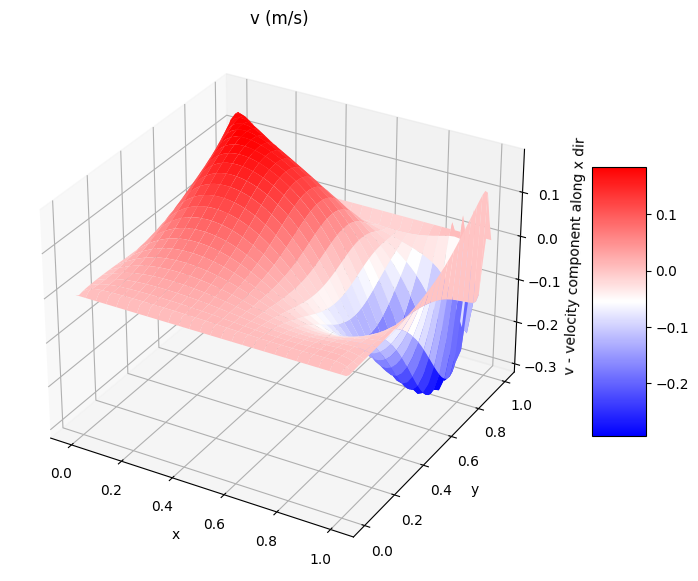

In [ ]:
fig = plt.figure(figsize = (11,7),dpi = 100)
ax = fig.add_subplot(projection = '3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('v - velocity component along x dir')
surf = ax.plot_surface(x_v,y_v,v,cmap='bwr')
fig.colorbar(surf,shrink = 0.5,aspect = 5)
plt.title("v (m/s)")
plt.show

In [ ]:
fig = plt.figure(figsize = (11,7),dpi = 100)
ax = fig.add_subplot(projection = '3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('p (Pa)')
surf = ax.plot_surface(x_p,y_p,P,cmap='bwr')
fig.colorbar(surf,shrink = 0.5,aspect = 5)

plt.title("pressure field")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>